# De l'importance de la cross-validation


Le but de ce notebook est de montrer pourquoi il est **crucial** de toujours cross valider vos résultats en ML. 


Pour rappel, nous sommes dans une approche prédictive : le but est de voir comment notre modèle va généraliser à de nouvelles données.

Pour cela, la procédure classique est de : 

1. Mélanger aléatoirement le dataset complet.
2. Diviser le dataset en ensemble d'entraînement et de test.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [2]:
# récupération des données
housing = fetch_california_housing(as_frame=True, data_home=".")

X, y = housing.data, housing.target

# 0. L'estimation de la capacité de généralisation du modèle dépend de choix arbitraires.

On peut appliquer la procédure évoquée plus haut une première fois. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=54)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("Test RMSE, seed=54: {:.3f}".format(rmse(y_test, lr.predict(X_test))))

Test RMSE, seed=54: 0.753


Le résultat est très bon, notre RMSE est de 0.75 ! On peut mettre notre algorithme en production ! Par acquis de conscience on va quand même vérifier avec une autre random seed, après tout celle qu'on a choisie est totalement arbitraire ...

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("Test RMSE, seed=22: {:.3f}".format(rmse(y_test, lr.predict(X_test))))

Test RMSE, seed=22: 0.701


On vient de perdre 7% alors que notre modèle n'a pas changé ! Que faut il désormais croire ? Quelle est la véritable capacité de généralisation du modèle ? 

## 1. La cross-validation permet de s'abstraire de cet arbitraire en simulant l'apprentissage et le test un grand nombre de fois.

On vient de montrer que si on fait un tirage unique (*une seule simulation de validation*), **le résultat est dû au hasard** : notre but est donc de voir quelle est la loi qui régit ce hasard en échantillonnant un grand nombre de fois. Certes le résultat sera dû au hasard mais un hasard contrôlé et connu.

Pour en avoir le coeur net, on simule 100 mélanges aléatoires différents, a priori ils sont tous aussi valables les uns que les autres.

In [9]:
results = {"train":[], "test":[], "coefs":[]}

for seed in range(100):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train, y_train)

    results["train"].append(rmse(pipe.predict(X_train), y_train))
    results["test"].append(rmse(pipe.predict(X_test), y_test))
    results["coefs"].append(pipe[-1].coef_)

Effectivement les résultats sont variables ...

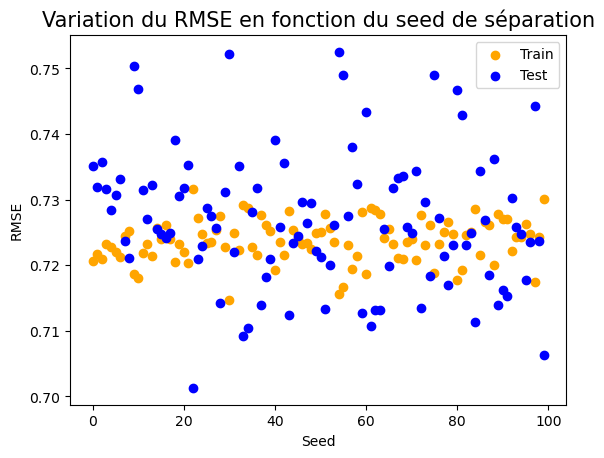

In [10]:
plt.scatter(range(100), results["train"], color='orange')
plt.scatter(range(100), results["test"], color='blue')
plt.xlabel("Seed")
plt.ylabel("RMSE")
plt.legend(["Train", "Test"])
plt.title("Variation du RMSE en fonction du seed de séparation", fontsize=15)
plt.show();


## 2. Et donne une estimation de la performance réélle du modèle

Plus qu'une simple estimation ponctuelle des performances de l'algo, on obtient une série de réalisations aléatoires qui nous permettent de dessiner une distribution.  

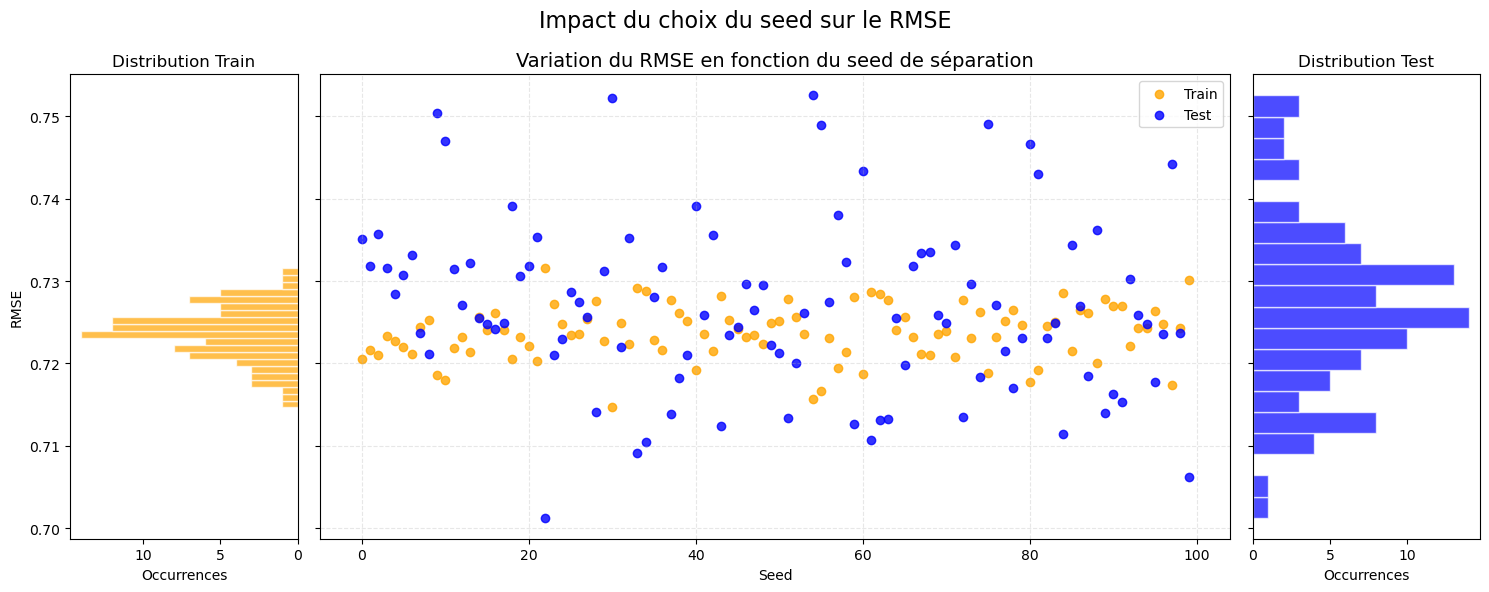

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [1, 4, 1]})

axes[0].hist(results["train"], orientation='horizontal', color='orange', bins=20, alpha=0.7, edgecolor='white')
axes[0].invert_xaxis()  
axes[0].set_title("Distribution Train")
axes[0].set_xlabel("Occurrences")
axes[0].set_ylabel("RMSE") 

axes[1].scatter(range(100), results["train"], color='orange', label='Train', alpha=0.8)
axes[1].scatter(range(100), results["test"], color='blue', label='Test', alpha=0.8)
axes[1].set_xlabel("Seed")
axes[1].set_title("Variation du RMSE en fonction du seed de séparation", fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

axes[2].hist(results["test"], orientation='horizontal', color='blue', bins=20, alpha=0.7, edgecolor='white')
axes[2].set_title("Distribution Test")
axes[2].set_xlabel("Occurrences")

plt.suptitle("Impact du choix du seed sur le RMSE", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

Et on peut donner des informations fiables sur la capacité de généralisation 

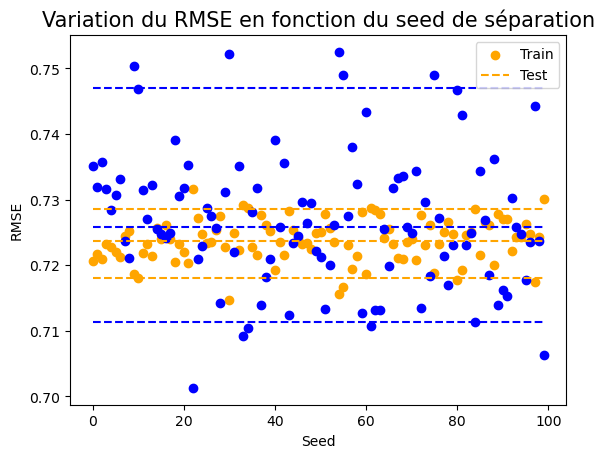

In [12]:
import numpy as np

plt.scatter(range(100), results["train"], color='orange')
train_q5, train_median, train_q95 = np.quantile(results["train"], [0.05, 0.5, 0.95])
plt.hlines([train_q5, train_median, train_q95], xmin=0, xmax=99, colors='orange', linestyles='dashed')

plt.scatter(range(100), results["test"], color='blue')
test_q5, test_median, test_q95 = np.quantile(results["test"], [0.05, 0.5, 0.95])
plt.hlines([test_q5, test_median, test_q95], xmin=0, xmax=99, colors='blue', linestyles='dashed')

plt.xlabel("Seed")
plt.ylabel("RMSE")
plt.legend(["Train", "Test"])
plt.title("Variation du RMSE en fonction du seed de séparation", fontsize=15)
plt.show();


## 3. Ainsi qu'un test de la stabilité de notre modèle

De la même manière, on peut aussi regarder la distribution des coefficients pour voir la stabilité de notre modèle et se faire une idée des éventuelles modifications.

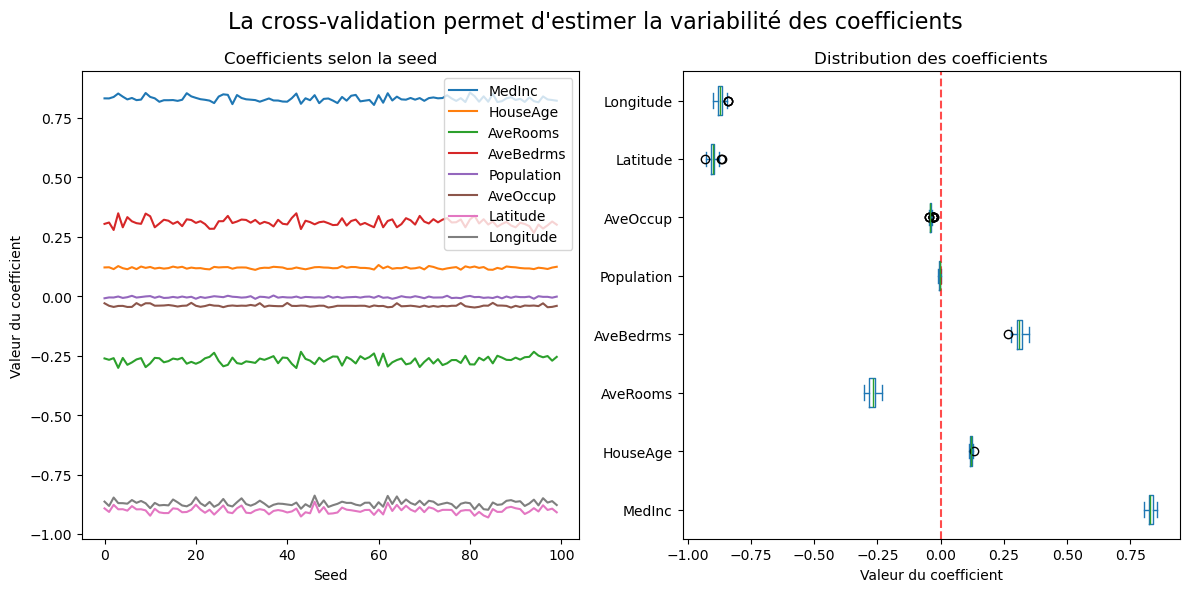

In [13]:
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

pd.DataFrame(results["coefs"]).plot(ax=axs[0])
axs[0].set_title("Coefficients selon la seed")
axs[0].legend(X.columns)
axs[0].set_xlabel("Seed")
axs[0].set_ylabel("Valeur du coefficient")

pd.DataFrame(results["coefs"]).plot(kind="box", vert=False, ax=axs[1])
axs[1].set_title("Distribution des coefficients")
axs[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axs[1].set_yticklabels(X.columns)
axs[1].set_xlabel("Valeur du coefficient")


plt.suptitle("La cross-validation permet d'estimer la variabilité des coefficients", fontsize=16)
plt.tight_layout()
plt.show()

La loi faible des grands nombres nous assure que si on fait ça un très grand nombre de fois, on va converger vers la véritable performance de généralisation du modèle. En pratique, faire ça 5 à 10 fois est souvent suffisant pour avoir une bonne idée de la performance réelle : c'est l'idée derrière la cross-validation et `KFold CV` et `Repeated KFold CV` en particulier.

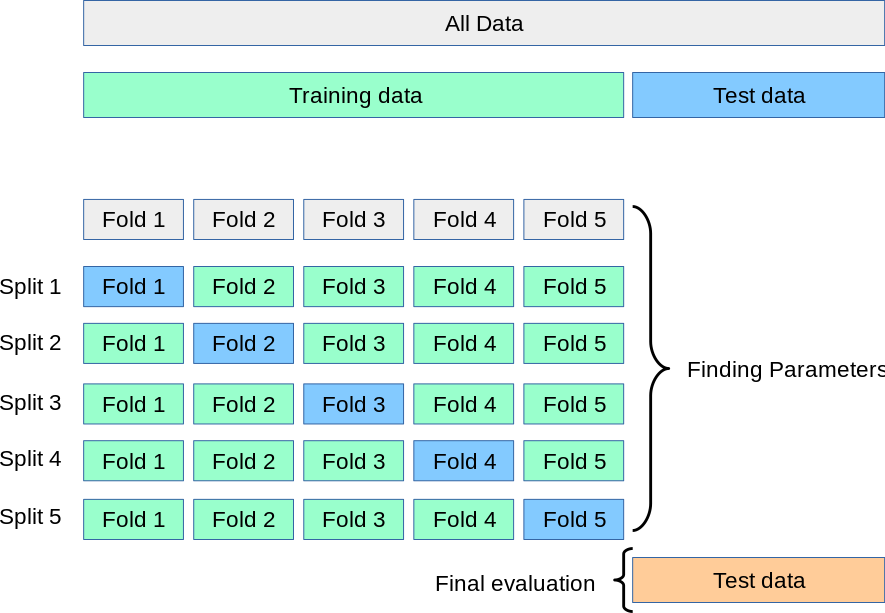

## 4. Le cas particulier des time-series 

Dans le cadre des séries temporelles l'ordre des données a un sens capital : passé, présent et futur. Cette donnée capitale crée 2 soucis :

1. mélanger aléatoirement les données détruirait de l'information (sur la succession dans le temps des mesures du phénomène que l'on étudie)
   
2. une approche de KFold classique induirait un **data leakage** : à l'exception du dernier fold, on prédit le passé en connaissant le futur alors même que l'on cherche à évaluer la capacité du modèle à prédire le futur sans évidemment le connaître ...

Pour pouvoir tout de même cross_valider les modèles, on utilise un schéma de validation particulier : le `TimeSeriesSplit`.


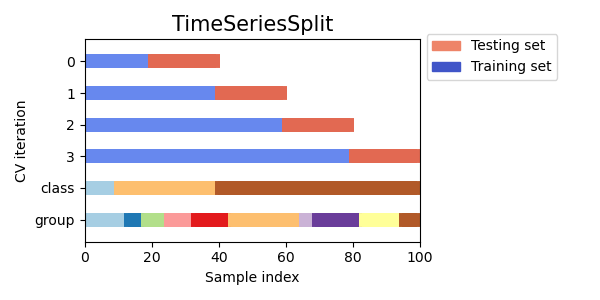

source : 

- [ts_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
- [cv_visualized](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
- [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html)

In [11]:
from sklearn.model_selection import TimeSeriesSplit

date_range = pd.date_range(start='2023-01-01', periods=100, freq='D')

cv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in cv.split(date_range):
    print("Train: du {} au {}, Test: du {} au {}".format(
        date_range[train_index[0]], date_range[train_index[-1]],
        date_range[test_index[0]], date_range[test_index[-1]]
    ))


Train: du 2023-01-01 00:00:00 au 2023-01-20 00:00:00, Test: du 2023-01-21 00:00:00 au 2023-02-05 00:00:00
Train: du 2023-01-01 00:00:00 au 2023-02-05 00:00:00, Test: du 2023-02-06 00:00:00 au 2023-02-21 00:00:00
Train: du 2023-01-01 00:00:00 au 2023-02-21 00:00:00, Test: du 2023-02-22 00:00:00 au 2023-03-09 00:00:00
Train: du 2023-01-01 00:00:00 au 2023-03-09 00:00:00, Test: du 2023-03-10 00:00:00 au 2023-03-25 00:00:00
Train: du 2023-01-01 00:00:00 au 2023-03-25 00:00:00, Test: du 2023-03-26 00:00:00 au 2023-04-10 00:00:00
